In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import os
import astropy.units as u

import StrainandNoise as SnN
import SNRcalc as SNc

# Directory Names

In [3]:
top_directory = os.getcwd() + '/LoadFiles/InstrumentStrainFiles/'
LISA_Other_filedirectory = top_directory + 'LISA_Other/'
LISA_Neil_filedirectory = top_directory + 'LISA_Neil/'
LISA_ESA_filedirectory = top_directory + 'LISA_ESA/'
ET_filedirectory = top_directory + 'EinsteinTelescope/'
aLIGO_filedirectory = top_directory + 'aLIGO/'
NANOGrav_filedirectory = top_directory + 'NANOGrav/' 

# Constants and Initial Parameters

In [4]:
'''
    Variables: 
        'M' - Mass (Solar Units)
        'q' - Mass Ratio
        'chi1' - Spin1
        'chi2' - Spin2
        'z' - Redshift
'''

var1 = 'z' #Variable on y-axis

sampleRate1 = 100 #Number of SNRMatrix rows

var2 = 'M' #Variable on x-axis

sampleRate2 = 100 #Number of SNRMatrix columns

#Selects which noise curve: 0 is Neil Cornish's,
# 							1 is the 2016 proposal,
#							2 is Einstein Telescope, 
#							3 is aLIGO, 
#							4 is NANOGrav 11yr,
#							5 is SKA (2030s),
#							anything else is the L3 proposal
model = 4

#TODO: make general intake of some f,and sqrt(S_n_f)

#M = m1+m2 Total Mass
M = 1e6
M_min = 1e1
M_max = 1e12

#q = m2/m1 reduced mass
q = 1.0
q_min = 1.0
q_max = 18.0

#Chi = S_i*L/m_i**2, spins of each mass i
chi1 = 0.0 #spin of m1
chi2 = 0.0 #spin of m2
chi_min = -0.85 #Limits of PhenomD for unaligned spins
chi_max = 0.85

z = 3.0 #Redshift
z_min = 1e-2
z_max = 1e3

nfreqs = int(1e3)   #Sample rate of strain/Transfer function frequencies

#Make a dictionary of dictionaries to put all values, minima, and maxima in a nice, concise form
var_dict = {'M':{'val':M,'min':M_min,'max':M_max},
            'q':{'val':q,'min':q_min,'max':q_max},
            'chi1':{'val':chi1,'min':chi_min,'max':chi_max},
            'chi2':{'val':chi2,'min':chi_min,'max':chi_max},
            'z':{'val':z,'min':z_min,'max':z_max}}

# Model Selection

In [5]:
if model == 0: #Neil
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    #Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf
    Neil_S_acc = 3e-15*u.m/u.s/u.s #M/sqrt(Hz)
    Neil_S_oms = 1.5e-11*u.m
    Neil_L = 2.5e9*u.m
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=Neil_L)    
    S_n_f_sqrt = SnN.NeilSensitivity(f,LISA_Transfer_Function)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 1: #Martin 2016
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    #LISA Calculation without pathfinder correction (2016 model)
    Ssci = 8.9e-12**2*u.m*u.m
    Sloc = 1.7e-12**2*u.m*u.m
    Sother = 2e-12**2*u.m*u.m
    k2016_P_ims = Ssci+2*Sloc+Sother
    k2016_L = 2.5e9*u.m
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=k2016_L)
    k2016_P_acc = ((1.8e-14*u.m/u.s/u.s)**2*((3e-5*u.Hz/f)**10 + (1e-4*u.Hz/f)**2) + (3e-15*u.m/u.s/u.s)**2)/(2*np.pi*f)**4   #red below 1e-4, white above
    
    S_n_f_sqrt = SnN.calcASD(f,LISA_Transfer_Function,k2016_P_acc,k2016_P_ims,k2016_L)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 2: #Einstein Telescope
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    ET_filename = 'ET_D_data.txt'
    ET_filelocation = ET_filedirectory + ET_filename
    ET_data = np.loadtxt(ET_filelocation)
    fT = ET_data[:,0]*u.Hz
    
    S_n_f_sqrt = ET_data[:,1]
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 3: #aLIGO
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    aLIGO_filename = 'aLIGODesign.txt'
    aLIGO_filelocation = aLIGO_filedirectory + aLIGO_filename
    aLIGO_data = np.loadtxt(aLIGO_filelocation)
    #Cheating with names so I don't have to load data everytime
    fT = aLIGO_data[:,0]*u.Hz
    
    S_n_f_sqrt = aLIGO_data[:,1]
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
elif model == 4: #NANOGrav 11 yr
    ###############################################
    #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
    deltrms_nano = 100*u.ns #rms timing residuals in seconds
    deltrms_nano = deltrms_nano.to('s')

    T_obs = 11.4*u.yr #Observing time in years
    T_obs = T_obs.to('s') #Observing time in seconds
    Np_nano = 45 #Number of pulsars
    cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
    cadence_nano = cadence_nano.to('1/s')
    ndetectors = 1
    
    fT,S_n_f_sqrt = SnN.calcPTAASD(deltrms_nano,cadence_nano,T_obs,ndetectors)
elif model == 5: #SKA (2030s)
    ###############################################
    #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
    deltrms_nano = 100*u.ns #rms timing residuals in seconds
    deltrms_nano = deltrms_nano.to('s')

    T_nano = 11.4*u.yr #Observing time in years
    T_nano = T_nano.to('s') #Observing time in seconds
    Np_nano = 45 #Number of pulsars
    cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
    cadence_nano = cadence_nano.to('1/s')
    
    ###############################################
    #SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
    deltrms_SKA = 10*u.ns #rms timing residuals in nanoseconds
    deltrms_SKA = deltrms_SKA.to('s')

    T_SKA = 15*u.yr #Observing time in years
    T_SKA = T_SKA.to('s') #Observing time in seconds

    Np_SKA = 20 #Number of pulsars
    cadence_SKA = 1/u.wk #Avg observation cadence of 1 every week in seconds
    cadence_SKA = cadence_SKA.to('1/s')
    
    ndetectors = 2
    T_obs_full = [T_nano, T_SKA]
    cadence_full = [cadence_nano, cadence_SKA]
    sigma_rms_full = [deltrms_nano, deltrms_SKA]
    
    T_obs=T_nano+T_SKA

    fT,S_n_f_sqrt = SnN.calcPTAASD(sigma_rms_full,cadence_full,T_obs_full,ndetectors)
else: #L3 proposal
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    S_acc_low_knee = .4*u.mHz
    S_acc_high_knee = 8.*u.mHz
    S_oms_knee = 2.*u.mHz
    ESA_L = 2.5e9*u.m
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=ESA_L)
    S_n_f_sqrt = SnN.LisaSensitivity(fT,LISA_Transfer_Function)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)

# Setting Up SNR Calculation
Uses the variables given and the data range to sample the space either logrithmically or linearly based on the 
selection of variables. Then it computes the SNR for each value.
Returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the sample1Xsample2


In [10]:
[sample1tmp,sample2tmp,SNRMatrixtmp] = SNc.getSNRMatrixVer10(var1,sampleRate1,var2,sampleRate2,var_dict,fT,S_n_f_sqrt,T_obs)

/home/andrew/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


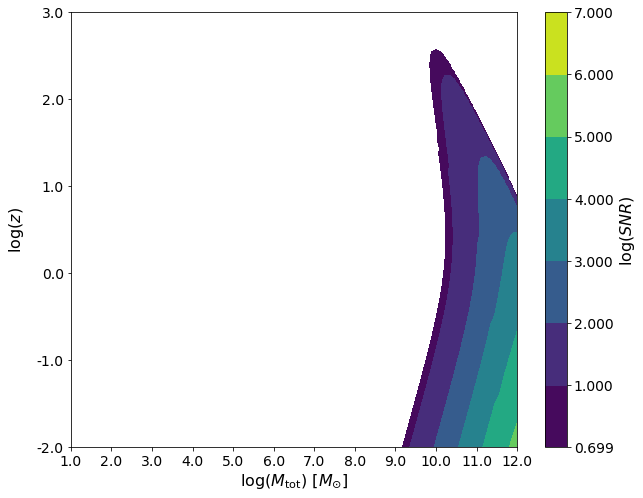

In [11]:
SNc.plotSNR(sample1tmp,sample2tmp,SNRMatrixtmp,var_dict,var1,var2)